Today, we will continue working on the inverted pendulum environment. However, the goal of this lab will be to implement one of the RL agents discussed in this week's lecture. Don't forget to download the new version of the environment under course contents. In the rest of this notebook, a Chainer skeleton code (with missing functionality) for the reinforce agent is provided. You can either work on finalizing the implementation of the reinforce agent or implement a different model of your choice.

In [1]:
import matplotlib.pyplot as plt
import tqdm
import numpy as np
from chainer import Chain
import chainer.links as L
import chainer.functions as F
from chainer.optimizers import Adam
from chainer import Variable
import random
import socket
import struct
import gym

%matplotlib inline

In [2]:
class AIGymEnv:
    def __init__(self):
        self.env = gym.make('CartPole-v1') 
    
    def reset(self):
        reward, state, done, _ = self.env.reset()
        if done:
            status = [1]
        else:
            status = [0]
        
        return reward, state, status
    
    
    def step(self, action, draw=False):
        if draw:
            self.env.render()
            
        observation, reward, done, info = self.env.step(action)
        
        if done:
            status = [1]
        else:
            status = [0]
        
        return reward, state, status
    

In [3]:
# same environment as last week

class Environment:
    def __init__(self, ip = "127.0.0.1", port = 13000):
        self.client = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.ip     = ip
        self.port   = port

        self.client.connect((ip, port))

    def reset(self):
        self._send(0, 0)
        return self._receive()

    def step(self, action):
        self._send(action, 1)
        return self._receive()

    def _receive(self):
        data = self.client.recv(19)
        reward = data[0]
        state = [struct.unpack("@f", data[1 + i * 4: 5 + i * 4])[0] for i in range(4)]
        status = [data[17], data[18]]
        return reward, state, status

    def _send(self, action, command):
        self.client.send(bytes([action, command]))

In [4]:
# Let's define a baseline agent which just emits random actions.


class RandomAgent:
    def __init__(self):
        pass

    def step(self, reward, state):
        return random.randint(0, 1)

Let's run the agent within the environment. (don't forget to start the environment)
if you want to see the agent, also don't forget to enable the camera in the GUI

In [15]:
episode_count = 1000

agent = RandomAgent()
environment = AIGymEnv()

In [18]:
R0 = np.zeros(episode_count)

for i in range(episode_count):
    reward, state, status = environment.reset()

    while (status[0] == 0):
        action = agent.step(reward, state)
        reward, state, status = environment.step(action)
        R0[i] += reward

In [19]:
# Let's create the REINFORCE agent. We assume that the policy is computed using an MLP with a softmax output.

class MLP(Chain):
    """Multilayer perceptron"""

    def __init__(self, n_output=1, n_hidden=5):
        super(MLP, self).__init__(l1=L.Linear(None, n_hidden), l2=L.Linear(n_hidden, n_output))

    def __call__(self, x):
        return self.l2(F.relu(self.l1(x)))

In [20]:
# A skeleton for the REINFORCEAgent is given. Implement the compute_loss and compute_score functions.

class REINFORCEAgent(object):
    """Agent trained using REINFORCE"""

    def __init__(self, model, optimizer=Adam()):
        self.model = model

        self.optimizer = optimizer
        self.optimizer.setup(self.model)

        # monitor score and reward
        self.rewards = []
        self.scores = []


    def step(self, reward, state):

        # linear outputs reflecting the log action probabilities and the value
        policy = self.model(Variable(np.atleast_2d(np.asarray(state, 'float32'))))

        # generate action according to policy
        p = F.softmax(policy).data

        # normalize p in case tiny floating precision problems occur
        row_sums = p.sum(axis=1)
        p /= row_sums[:, np.newaxis]

        action = np.asarray([np.random.choice(p.shape[1], None, True, p[0])])

        return action, policy
    

    def compute_loss(self):
        """
        Return loss for this episode based on computed scores and accumulated rewards
        """
    
        # cost to go
        Qhat = 0

        loss = 0
        for t in range(len(self.rewards) - 1, -1, -1):

            Qhat = self.rewards.pop() + Qhat

            _ss = F.squeeze(self.scores.pop(), axis=1) * Qhat

            if _ss.size > 1:
                _ss = F.sum(_ss, axis=0)
            loss += F.squeeze(_ss)

        return loss


    def compute_score(self, action, policy):
        """
        Computes score

        Args:
            action (int):
            policy:

        Returns:
            score
        """

        logp = F.log_softmax(policy)
    
        score = F.select_item(logp, Variable(action))

        # handle case where we have only one element per batch
        if score.ndim == 1:
            score = F.expand_dims(score, axis=1)

        return score

In [21]:
# Now we run the REINFORCE agent within the environment. Note that we update the agent after each episode for simplicity.
# First, we should restart the server from the GUI

environment = AIGymEnv()
network = MLP(n_output=2, n_hidden=3)
agent = REINFORCEAgent(network, optimizer=Adam())
    
R = np.zeros(episode_count)


In [22]:
for i in tqdm.trange(episode_count):

    reward, state, status = environment.reset()

    loss = 0
    while True:

        action, policy = agent.step(reward, state)

        reward, state, status = environment.step(action[0])

        # get reward associated with taking the previous action in the previous state
        agent.rewards.append(reward)
        R[i] += reward

        # recompute score function: grad_theta log pi_theta (s_t, a_t) * v_t
        agent.scores.append(agent.compute_score(action, policy))

        # we learn at the end of each episode
        if status[0] == 1:
            
            loss += agent.compute_loss()
            
            agent.model.cleargrads()
            loss.backward()
            loss.unchain_backward()
            agent.optimizer.update()

            break

100%|██████████| 1000/1000 [00:51<00:00, 19.40it/s]


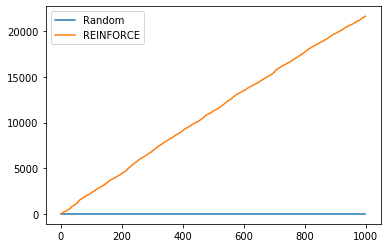

In [23]:
# and we finally plot the accumulated reward per episode

plt.figure()
plt.plot(np.cumsum(R0))
plt.plot(np.cumsum(R))
plt.legend(['Random', 'REINFORCE'])
plt.show()

In [52]:
# A skeleton for the DQNAgent is given. Implement the compute_loss and compute_score functions.

class DQNAgent(object):
    """Agent trained using DQN"""

    def __init__(self, qnet, qhatnet, optimizer=Adam()):
        self.qnet = qnet
        self.qhatnet = qhatnet

        self.optimizer = optimizer
        self.optimizer.setup(self.qnet)
        
        self.eta = .5
        
        self.buffer = []

        # monitor score and reward
        self.rewards = []
        self.scores = []


    def step(self, reward, state):

        
        # "toss a coin" to decide whether to take a random action
        coin = np.random.rand()
        
        # if random action
        if coin <= self.eta:
            return random.randint(0, 1)
        
        # linear outputs reflecting the log action probabilities and the value
        Qvals = self.qhatnet(Variable(np.atleast_2d(np.asarray(state, 'float32')))).data
        print("Qvalues: ", Qvals)
        maxQ = np.amax(Qvals)
        print("best Q: ", maxQ)
        action = np.where(Qvals == maxQ)[0][0]
        return action 
    

    def compute_loss(self):
        """
        Return loss for this episode based on computed scores and accumulated rewards
        """
    
        # cost to go
        Qhat = 0

        loss = 0
        for t in range(len(self.rewards) - 1, -1, -1):

            Qhat = self.rewards.pop() + Qhat

            _ss = F.squeeze(self.scores.pop(), axis=1) * Qhat

            if _ss.size > 1:
                _ss = F.sum(_ss, axis=0)
            loss += F.squeeze(_ss)

        return loss


    def compute_score(self, action, policy):
        """
        Computes score

        Args:
            action (int):
            policy:

        Returns:
            score
        """

        logp = F.log_softmax(policy)
    
        score = F.select_item(logp, Variable(action))

        # handle case where we have only one element per batch
        if score.ndim == 1:
            score = F.expand_dims(score, axis=1)

        return score

In [53]:
# Now we run the DQN agent within the environment. Note that we update the agent after each episode for simplicity.
# First, we should restart the server from the GUI

environment = AIGymEnv()

qnet = MLP(n_output=2, n_hidden=3)
qhatnet = MLP(n_output=2, n_hidden=3)

agent = DQNAgent(qnet, qhatnet, optimizer=Adam())
    
R_DQN = np.zeros(episode_count)


In [54]:
for i in tqdm.trange(episode_count):

    reward, state, status = environment.reset()

    loss = 0
    while True:

        action = agent.step(reward, state)
        print(action)

        reward, state, status = environment.step(action)

        # get reward associated with taking the previous action in the previous state
        agent.rewards.append(reward)
        R[i] += reward

        
        # we learn at the end of each episode
        if status[0] == 1:

            break

  2%|▏         | 22/1000 [00:00<00:09, 105.72it/s]

1
Qvalues:  [[-0.00886648 -0.00153124]]
best Q:  -0.0015312417
0
1
Qvalues:  [[-0.00886648 -0.00153124]]
best Q:  -0.0015312417
0
0
1
Qvalues:  [[-0.00886648 -0.00153124]]
best Q:  -0.0015312417
0
1
Qvalues:  [[-0.00886648 -0.00153124]]
best Q:  -0.0015312417
0
Qvalues:  [[-0.00886648 -0.00153124]]
best Q:  -0.0015312417
0
Qvalues:  [[-0.00886648 -0.00153124]]
best Q:  -0.0015312417
0
1
1
1
Qvalues:  [[-0.00886648 -0.00153124]]
best Q:  -0.0015312417
0
Qvalues:  [[-0.00886648 -0.00153124]]
best Q:  -0.0015312417
0
1
Qvalues:  [[-0.00886648 -0.00153124]]
best Q:  -0.0015312417
0
Qvalues:  [[-0.00886648 -0.00153124]]
best Q:  -0.0015312417
0
Qvalues:  [[-0.00886648 -0.00153124]]
best Q:  -0.0015312417
0
1
Qvalues:  [[-0.00886648 -0.00153124]]
best Q:  -0.0015312417
0
1
Qvalues:  [[-0.03405746 -0.00588172]]
best Q:  -0.0058817235
0
0
Qvalues:  [[-0.03405746 -0.00588172]]
best Q:  -0.0058817235
0
Qvalues:  [[-0.03405746 -0.00588172]]
best Q:  -0.0058817235
0
0
Qvalues:  [[-0.03405746 -0.00

  4%|▍         | 38/1000 [00:00<00:11, 85.39it/s] 

Qvalues:  [[0.01246225 0.01512102]]
best Q:  0.015121022
0
Qvalues:  [[0.01246225 0.01512102]]
best Q:  0.015121022
0
1
Qvalues:  [[0.01246225 0.01512102]]
best Q:  0.015121022
0
Qvalues:  [[0.01246225 0.01512102]]
best Q:  0.015121022
0
Qvalues:  [[0.01246225 0.01512102]]
best Q:  0.015121022
0
Qvalues:  [[0.01246225 0.01512102]]
best Q:  0.015121022
0
0
1
Qvalues:  [[0.01246225 0.01512102]]
best Q:  0.015121022
0
Qvalues:  [[0.01246225 0.01512102]]
best Q:  0.015121022
0
Qvalues:  [[0.01246225 0.01512102]]
best Q:  0.015121022
0
0
Qvalues:  [[0.01246225 0.01512102]]
best Q:  0.015121022
0
1
Qvalues:  [[0.01246225 0.01512102]]
best Q:  0.015121022
0
0
1
Qvalues:  [[0.01246225 0.01512102]]
best Q:  0.015121022
0
Qvalues:  [[0.01246225 0.01512102]]
best Q:  0.015121022
0
0
Qvalues:  [[-0.01008518 -0.00174171]]
best Q:  -0.0017417098
0
0
1
Qvalues:  [[-0.01008518 -0.00174171]]
best Q:  -0.0017417098
0
0
1
Qvalues:  [[-0.01008518 -0.00174171]]
best Q:  -0.0017417098
0
1
Qvalues:  [[-0.010

  6%|▋         | 63/1000 [00:00<00:10, 86.94it/s]

Qvalues:  [[0.00624334 0.00757533]]
best Q:  0.0075753294
0
Qvalues:  [[0.00624334 0.00757533]]
best Q:  0.0075753294
0
0
1
0
Qvalues:  [[0.00624334 0.00757533]]
best Q:  0.0075753294
0
0
1
Qvalues:  [[0.00624334 0.00757533]]
best Q:  0.0075753294
0
Qvalues:  [[0.00624334 0.00757533]]
best Q:  0.0075753294
0
Qvalues:  [[0.00624334 0.00757533]]
best Q:  0.0075753294
0
Qvalues:  [[0.00624334 0.00757533]]
best Q:  0.0075753294
0
Qvalues:  [[0.01817496 0.02205252]]
best Q:  0.02205252
0
0
Qvalues:  [[0.01817496 0.02205252]]
best Q:  0.02205252
0
Qvalues:  [[0.01817496 0.02205252]]
best Q:  0.02205252
0
1
Qvalues:  [[0.01817496 0.02205252]]
best Q:  0.02205252
0
Qvalues:  [[0.01817496 0.02205252]]
best Q:  0.02205252
0
Qvalues:  [[0.01817496 0.02205252]]
best Q:  0.02205252
0
1
Qvalues:  [[0.01817496 0.02205252]]
best Q:  0.02205252
0
0
0
Qvalues:  [[0.00729949 0.00885681]]
best Q:  0.008856807
0
0
Qvalues:  [[0.00729949 0.00885681]]
best Q:  0.008856807
0
Qvalues:  [[0.00729949 0.00885681]

  8%|▊         | 81/1000 [00:00<00:10, 85.01it/s]

best Q:  0.00854559
0
1
Qvalues:  [[0.00704299 0.00854559]]
best Q:  0.00854559
0
1
0
0
1
Qvalues:  [[0.00704299 0.00854559]]
best Q:  0.00854559
0
1
Qvalues:  [[0.00704299 0.00854559]]
best Q:  0.00854559
0
Qvalues:  [[0.01373725 0.01666804]]
best Q:  0.016668044
0
Qvalues:  [[0.01373725 0.01666804]]
best Q:  0.016668044
0
0
Qvalues:  [[0.01373725 0.01666804]]
best Q:  0.016668044
0
0
Qvalues:  [[0.01373725 0.01666804]]
best Q:  0.016668044
0
1
0
1
Qvalues:  [[0.01373725 0.01666804]]
best Q:  0.016668044
0
1
Qvalues:  [[0.00378041 0.00458695]]
best Q:  0.0045869467
0
1
1
1
1
Qvalues:  [[0.00378041 0.00458695]]
best Q:  0.0045869467
0
Qvalues:  [[0.00378041 0.00458695]]
best Q:  0.0045869467
0
0
Qvalues:  [[0.00378041 0.00458695]]
best Q:  0.0045869467
0
0
Qvalues:  [[0.00378041 0.00458695]]
best Q:  0.0045869467
0
1
Qvalues:  [[0.00378041 0.00458695]]
best Q:  0.0045869467
0
Qvalues:  [[0.00378041 0.00458695]]
best Q:  0.0045869467
0
Qvalues:  [[0.00378041 0.00458695]]
best Q:  0.0045

 10%|▉         | 99/1000 [00:01<00:10, 86.26it/s]

0
0
Qvalues:  [[0.02796856 0.03393555]]
best Q:  0.03393555
0
1
Qvalues:  [[-0.0112625  -0.00194503]]
best Q:  -0.0019450338
0
1
Qvalues:  [[-0.0112625  -0.00194503]]
best Q:  -0.0019450338
0
Qvalues:  [[-0.0112625  -0.00194503]]
best Q:  -0.0019450338
0
1
1
Qvalues:  [[-0.0112625  -0.00194503]]
best Q:  -0.0019450338
0
Qvalues:  [[-0.0112625  -0.00194503]]
best Q:  -0.0019450338
0
1
0
0
0
0
1
Qvalues:  [[-0.01930264 -0.00333357]]
best Q:  -0.0033335665
0
Qvalues:  [[-0.01930264 -0.00333357]]
best Q:  -0.0033335665
0
1
1
0
1
Qvalues:  [[-0.01930264 -0.00333357]]
best Q:  -0.0033335665
0
Qvalues:  [[-0.01930264 -0.00333357]]
best Q:  -0.0033335665
0
Qvalues:  [[-0.01930264 -0.00333357]]
best Q:  -0.0033335665
0
Qvalues:  [[-0.01930264 -0.00333357]]
best Q:  -0.0033335665
0
Qvalues:  [[-0.01930264 -0.00333357]]
best Q:  -0.0033335665
0
0
1
0
0
Qvalues:  [[-0.01930264 -0.00333357]]
best Q:  -0.0033335665
0
0
0
Qvalues:  [[-0.00298589 -0.00051566]]
best Q:  -0.0005156638
0
Qvalues:  [[-0.0

 13%|█▎        | 132/1000 [00:01<00:08, 103.33it/s]

best Q:  0.048989683
0
Qvalues:  [[0.04037568 0.04898968]]
best Q:  0.048989683
0
1
Qvalues:  [[0.04037568 0.04898968]]
best Q:  0.048989683
0
1
Qvalues:  [[0.04037568 0.04898968]]
best Q:  0.048989683
0
Qvalues:  [[0.04037568 0.04898968]]
best Q:  0.048989683
0
Qvalues:  [[0.04037568 0.04898968]]
best Q:  0.048989683
0
Qvalues:  [[0.04037568 0.04898968]]
best Q:  0.048989683
0
1
Qvalues:  [[0.04037568 0.04898968]]
best Q:  0.048989683
0
0
Qvalues:  [[0.04037568 0.04898968]]
best Q:  0.048989683
0
Qvalues:  [[0.03079777 0.03736836]]
best Q:  0.037368365
0
1
Qvalues:  [[0.03079777 0.03736836]]
best Q:  0.037368365
0
Qvalues:  [[0.03079777 0.03736836]]
best Q:  0.037368365
0
0
0
Qvalues:  [[0.03079777 0.03736836]]
best Q:  0.037368365
0
1
1
Qvalues:  [[0.03079777 0.03736836]]
best Q:  0.037368365
0
Qvalues:  [[0.03079777 0.03736836]]
best Q:  0.037368365
0
1
1
1
Qvalues:  [[0.03079777 0.03736836]]
best Q:  0.037368365
0
0
0
Qvalues:  [[0.04908959 0.05956268]]
best Q:  0.059562683
0
Qvalu

 14%|█▍        | 144/1000 [00:01<00:11, 77.54it/s] 

[[-0.01256207 -0.00216947]]
best Q:  -0.0021694698
0
0
0
1
1
0
0
Qvalues:  [[-0.00363683 -0.00062808]]
best Q:  -0.00062808
0
Qvalues:  [[-0.00363683 -0.00062808]]
best Q:  -0.00062808
0
Qvalues:  [[-0.00363683 -0.00062808]]
best Q:  -0.00062808
0
Qvalues:  [[-0.00363683 -0.00062808]]
best Q:  -0.00062808
0
0
1
Qvalues:  [[-0.00363683 -0.00062808]]
best Q:  -0.00062808
0
0
1
Qvalues:  [[-0.04344266 -0.00750255]]
best Q:  -0.0075025465
0
Qvalues:  [[-0.04344266 -0.00750255]]
best Q:  -0.0075025465
0
Qvalues:  [[-0.04344266 -0.00750255]]
best Q:  -0.0075025465
0
1
Qvalues:  [[-0.04344266 -0.00750255]]
best Q:  -0.0075025465
0
0
0
Qvalues:  [[-0.04344266 -0.00750255]]
best Q:  -0.0075025465
0
1
Qvalues:  [[-0.04344266 -0.00750255]]
best Q:  -0.0075025465
0
1
Qvalues:  [[0.04908292 0.05955458]]
best Q:  0.059554584
0
1
1
1
Qvalues:  [[0.04908292 0.05955458]]
best Q:  0.059554584
0
1
Qvalues:  [[0.04908292 0.05955458]]
best Q:  0.059554584
0
1
Qvalues:  [[0.04908292 0.05955458]]
best Q:  0.

 18%|█▊        | 180/1000 [00:01<00:08, 100.18it/s]

best Q:  -0.008897967
0
0
Qvalues:  [[-0.05152268 -0.00889797]]
best Q:  -0.008897967
0
Qvalues:  [[0.04921288 0.05971227]]
best Q:  0.05971227
0
Qvalues:  [[0.04921288 0.05971227]]
best Q:  0.05971227
0
Qvalues:  [[0.04921288 0.05971227]]
best Q:  0.05971227
0
Qvalues:  [[0.04921288 0.05971227]]
best Q:  0.05971227
0
1
0
1
1
1
Qvalues:  [[0.04921288 0.05971227]]
best Q:  0.05971227
0
Qvalues:  [[0.04921288 0.05971227]]
best Q:  0.05971227
0
0
0
Qvalues:  [[0.04921288 0.05971227]]
best Q:  0.05971227
0
0
0
Qvalues:  [[-0.02498005 -0.00431405]]
best Q:  -0.0043140543
0
Qvalues:  [[-0.02498005 -0.00431405]]
best Q:  -0.0043140543
0
0
0
Qvalues:  [[-0.02498005 -0.00431405]]
best Q:  -0.0043140543
0
0
0
Qvalues:  [[-0.02498005 -0.00431405]]
best Q:  -0.0043140543
0
1
0
Qvalues:  [[0.01944018 0.02358767]]
best Q:  0.023587672
0
0
0
Qvalues:  [[0.01944018 0.02358767]]
best Q:  0.023587672
0
Qvalues:  [[0.01944018 0.02358767]]
best Q:  0.023587672
0
1
0
1
Qvalues:  [[0.01944018 0.02358767]]
b

 19%|█▉        | 192/1000 [00:02<00:10, 80.37it/s] 

0
0
1
1
Qvalues:  [[-0.04765449 -0.00822993]]
best Q:  -0.00822993
0
0
Qvalues:  [[-0.04765449 -0.00822993]]
best Q:  -0.00822993
0
1
Qvalues:  [[-0.04765449 -0.00822993]]
best Q:  -0.00822993
0
0
Qvalues:  [[-0.04765449 -0.00822993]]
best Q:  -0.00822993
0
Qvalues:  [[-0.04765449 -0.00822993]]
best Q:  -0.00822993
0
Qvalues:  [[-0.04765449 -0.00822993]]
best Q:  -0.00822993
0
0
1
0
0
Qvalues:  [[0.03613545 0.04384482]]
best Q:  0.043844823
0
Qvalues:  [[0.03613545 0.04384482]]
best Q:  0.043844823
0
0
1
0
Qvalues:  [[0.03613545 0.04384482]]
best Q:  0.043844823
0
0
1
Qvalues:  [[0.03613545 0.04384482]]
best Q:  0.043844823
0
Qvalues:  [[0.03613545 0.04384482]]
best Q:  0.043844823
0
0
0
Qvalues:  [[-0.02232183 -0.00385498]]
best Q:  -0.0038549793
0
Qvalues:  [[-0.02232183 -0.00385498]]
best Q:  -0.0038549793
0
1
0
0
0
Qvalues:  [[-0.02232183 -0.00385498]]
best Q:  -0.0038549793
0
1
0
0
1
1
Qvalues:  [[-0.00863917 -0.00149198]]
best Q:  -0.0014919841
0
0
Qvalues:  [[-0.00863917 -0.0014

 23%|██▎       | 228/1000 [00:02<00:07, 105.90it/s]


1
0
0
0
Qvalues:  [[0.01107405 0.01343666]]
best Q:  0.013436662
0
0
Qvalues:  [[-0.02667954 -0.00460756]]
best Q:  -0.004607556
0
0
Qvalues:  [[-0.02667954 -0.00460756]]
best Q:  -0.004607556
0
Qvalues:  [[-0.02667954 -0.00460756]]
best Q:  -0.004607556
0
0
Qvalues:  [[-0.02667954 -0.00460756]]
best Q:  -0.004607556
0
Qvalues:  [[-0.02667954 -0.00460756]]
best Q:  -0.004607556
0
0
Qvalues:  [[0.04596947 0.05577689]]
best Q:  0.055776894
0
Qvalues:  [[0.04596947 0.05577689]]
best Q:  0.055776894
0
Qvalues:  [[0.04596947 0.05577689]]
best Q:  0.055776894
0
Qvalues:  [[0.04596947 0.05577689]]
best Q:  0.055776894
0
0
Qvalues:  [[0.04596947 0.05577689]]
best Q:  0.055776894
0
0
0
0
0
0
1
Qvalues:  [[0.00894589 0.01085446]]
best Q:  0.01085446
0
1
Qvalues:  [[0.00894589 0.01085446]]
best Q:  0.01085446
0
Qvalues:  [[0.00894589 0.01085446]]
best Q:  0.01085446
0
Qvalues:  [[0.00894589 0.01085446]]
best Q:  0.01085446
0
0
0
Qvalues:  [[0.00894589 0.01085446]]
best Q:  0.01085446
0
Qvalues: 

 24%|██▍       | 241/1000 [00:02<00:08, 84.48it/s] 

[[0.00786959 0.00954854]]
best Q:  0.009548538
0
Qvalues:  [[0.00786959 0.00954854]]
best Q:  0.009548538
0
Qvalues:  [[0.00786959 0.00954854]]
best Q:  0.009548538
0
1
1
Qvalues:  [[0.00786959 0.00954854]]
best Q:  0.009548538
0
Qvalues:  [[0.00786959 0.00954854]]
best Q:  0.009548538
0
Qvalues:  [[0.00786959 0.00954854]]
best Q:  0.009548538
0
Qvalues:  [[0.02619079 0.0317785 ]]
best Q:  0.0317785
0
0
Qvalues:  [[0.02619079 0.0317785 ]]
best Q:  0.0317785
0
0
1
0
1
Qvalues:  [[0.02619079 0.0317785 ]]
best Q:  0.0317785
0
1
Qvalues:  [[0.02619079 0.0317785 ]]
best Q:  0.0317785
0
1
0
0
Qvalues:  [[0.00663259 0.00804763]]
best Q:  0.008047634
0
Qvalues:  [[0.00663259 0.00804763]]
best Q:  0.008047634
0
0
Qvalues:  [[0.00663259 0.00804763]]
best Q:  0.008047634
0
1
1
Qvalues:  [[0.00663259 0.00804763]]
best Q:  0.008047634
0
Qvalues:  [[0.00663259 0.00804763]]
best Q:  0.008047634
0
Qvalues:  [[0.00663259 0.00804763]]
best Q:  0.008047634
0
Qvalues:  [[0.00663259 0.00804763]]
best Q:  0

 27%|██▋       | 266/1000 [00:02<00:07, 94.18it/s]

 [[-0.04807555 -0.00830265]]
best Q:  -0.008302647
0
0
Qvalues:  [[-0.04807555 -0.00830265]]
best Q:  -0.008302647
0
Qvalues:  [[-0.04807555 -0.00830265]]
best Q:  -0.008302647
0
0
Qvalues:  [[-0.04807555 -0.00830265]]
best Q:  -0.008302647
0
Qvalues:  [[0.01384699 0.0168012 ]]
best Q:  0.0168012
0
0
1
1
Qvalues:  [[0.01384699 0.0168012 ]]
best Q:  0.0168012
0
1
Qvalues:  [[0.01384699 0.0168012 ]]
best Q:  0.0168012
0
0
0
Qvalues:  [[0.01384699 0.0168012 ]]
best Q:  0.0168012
0
Qvalues:  [[0.01384699 0.0168012 ]]
best Q:  0.0168012
0
1
Qvalues:  [[0.01384699 0.0168012 ]]
best Q:  0.0168012
0
Qvalues:  [[0.01384699 0.0168012 ]]
best Q:  0.0168012
0
0
Qvalues:  [[0.01384699 0.0168012 ]]
best Q:  0.0168012
0
0
1
0
0
Qvalues:  [[0.01685868 0.02045542]]
best Q:  0.020455418
0
1
0
Qvalues:  [[0.01685868 0.02045542]]
best Q:  0.020455418
0
Qvalues:  [[0.01685868 0.02045542]]
best Q:  0.020455418
0
Qvalues:  [[0.01685868 0.02045542]]
best Q:  0.020455418
0
Qvalues:  [[0.01685868 0.02045542]]
b

 29%|██▉       | 293/1000 [00:03<00:07, 97.16it/s] 

0
Qvalues:  [[0.00926887 0.01124635]]
best Q:  0.011246352
0
0
Qvalues:  [[0.00926887 0.01124635]]
best Q:  0.011246352
0
Qvalues:  [[0.00926887 0.01124635]]
best Q:  0.011246352
0
1
Qvalues:  [[-0.02355551 -0.00406804]]
best Q:  -0.004068036
0
0
1
Qvalues:  [[-0.02355551 -0.00406804]]
best Q:  -0.004068036
0
0
1
1
Qvalues:  [[-0.02355551 -0.00406804]]
best Q:  -0.004068036
0
1
Qvalues:  [[-0.02355551 -0.00406804]]
best Q:  -0.004068036
0
0
0
1
Qvalues:  [[-0.02355551 -0.00406804]]
best Q:  -0.004068036
0
1
1
0
0
Qvalues:  [[0.024212   0.02937755]]
best Q:  0.029377546
0
Qvalues:  [[0.024212   0.02937755]]
best Q:  0.029377546
0
Qvalues:  [[0.024212   0.02937755]]
best Q:  0.029377546
0
1
0
1
1
Qvalues:  [[0.024212   0.02937755]]
best Q:  0.029377546
0
Qvalues:  [[0.024212   0.02937755]]
best Q:  0.029377546
0
1
Qvalues:  [[0.024212   0.02937755]]
best Q:  0.029377546
0
0
0
Qvalues:  [[0.024212   0.02937755]]
best Q:  0.029377546
0
0
0
Qvalues:  [[-0.03045788 -0.00526008]]
best Q:  -0.

 30%|███       | 305/1000 [00:03<00:06, 101.62it/s]

[[-0.02339919 -0.00404104]]
best Q:  -0.00404104
0
0
0
1
Qvalues:  [[-0.02339919 -0.00404104]]
best Q:  -0.00404104
0
0
Qvalues:  [[-0.02339919 -0.00404104]]
best Q:  -0.00404104
0
1
0
1
1
Qvalues:  [[-0.04103754 -0.00708718]]
best Q:  -0.0070871827
0
Qvalues:  [[-0.04103754 -0.00708718]]
best Q:  -0.0070871827
0
1
0
Qvalues:  [[-0.04103754 -0.00708718]]
best Q:  -0.0070871827
0
1
1
1
1
Qvalues:  [[-0.04103754 -0.00708718]]
best Q:  -0.0070871827
0
0
Qvalues:  [[-0.04103754 -0.00708718]]
best Q:  -0.0070871827
0
Qvalues:  [[-0.04103754 -0.00708718]]
best Q:  -0.0070871827
0
1
1
0
Qvalues:  [[-0.04103754 -0.00708718]]
best Q:  -0.0070871827
0
1
1
0
Qvalues:  [[-0.04103754 -0.00708718]]
best Q:  -0.0070871827
0
Qvalues:  [[-0.04103754 -0.00708718]]
best Q:  -0.0070871827
0
1
1
Qvalues:  [[-0.04103754 -0.00708718]]
best Q:  -0.0070871827
0
Qvalues:  [[-0.04103754 -0.00708718]]
best Q:  -0.0070871827
0
Qvalues:  [[-0.04103754 -0.00708718]]
best Q:  -0.0070871827
0
Qvalues:  [[-0.04103754 -

 33%|███▎      | 328/1000 [00:03<00:07, 85.15it/s] 

 [[-0.02687728 -0.00464171]]
best Q:  -0.004641706
0
Qvalues:  [[-0.02687728 -0.00464171]]
best Q:  -0.004641706
0
Qvalues:  [[-0.02687728 -0.00464171]]
best Q:  -0.004641706
0
0
Qvalues:  [[0.04943698 0.05998418]]
best Q:  0.05998418
0
Qvalues:  [[0.04943698 0.05998418]]
best Q:  0.05998418
0
Qvalues:  [[0.04943698 0.05998418]]
best Q:  0.05998418
0
Qvalues:  [[0.04943698 0.05998418]]
best Q:  0.05998418
0
Qvalues:  [[0.04943698 0.05998418]]
best Q:  0.05998418
0
Qvalues:  [[0.04943698 0.05998418]]
best Q:  0.05998418
0
Qvalues:  [[0.04943698 0.05998418]]
best Q:  0.05998418
0
0
Qvalues:  [[-0.00522392 -0.00090217]]
best Q:  -0.0009021702
0
0
Qvalues:  [[-0.00522392 -0.00090217]]
best Q:  -0.0009021702
0
Qvalues:  [[-0.00522392 -0.00090217]]
best Q:  -0.0009021702
0
Qvalues:  [[-0.00522392 -0.00090217]]
best Q:  -0.0009021702
0
1
Qvalues:  [[-0.00522392 -0.00090217]]
best Q:  -0.0009021702
0
0
Qvalues:  [[-0.00522392 -0.00090217]]
best Q:  -0.0009021702
0
0
Qvalues:  [[-0.00522392 -0.

 34%|███▍      | 343/1000 [00:03<00:06, 96.58it/s]


best Q:  -0.0029521764
0
0
1
Qvalues:  [[-0.01709425 -0.00295218]]
best Q:  -0.0029521764
0
Qvalues:  [[-0.01709425 -0.00295218]]
best Q:  -0.0029521764
0
Qvalues:  [[-0.01709425 -0.00295218]]
best Q:  -0.0029521764
0
1
0
1
Qvalues:  [[-0.01709425 -0.00295218]]
best Q:  -0.0029521764
0
Qvalues:  [[-0.01709425 -0.00295218]]
best Q:  -0.0029521764
0
Qvalues:  [[-0.01709425 -0.00295218]]
best Q:  -0.0029521764
0
Qvalues:  [[-0.03102926 -0.00535875]]
best Q:  -0.0053587523
0
Qvalues:  [[-0.03102926 -0.00535875]]
best Q:  -0.0053587523
0
0
Qvalues:  [[-0.03102926 -0.00535875]]
best Q:  -0.0053587523
0
Qvalues:  [[-0.03102926 -0.00535875]]
best Q:  -0.0053587523
0
1
0
0
Qvalues:  [[-0.03102926 -0.00535875]]
best Q:  -0.0053587523
0
0
Qvalues:  [[-0.05076824 -0.00876767]]
best Q:  -0.008767675
0
1
1
Qvalues:  [[-0.05076824 -0.00876767]]
best Q:  -0.008767675
0
Qvalues:  [[-0.05076824 -0.00876767]]
best Q:  -0.008767675
0
1
1
Qvalues:  [[-0.05076824 -0.00876767]]
best Q:  -0.008767675
0
Qvalu

 36%|███▋      | 365/1000 [00:03<00:07, 80.23it/s]

 [[-0.01114382 -0.00192454]]
best Q:  -0.0019245376
0
Qvalues:  [[-0.01114382 -0.00192454]]
best Q:  -0.0019245376
0
Qvalues:  [[-0.01114382 -0.00192454]]
best Q:  -0.0019245376
0
0
Qvalues:  [[-0.01114382 -0.00192454]]
best Q:  -0.0019245376
0
0
Qvalues:  [[-0.01114382 -0.00192454]]
best Q:  -0.0019245376
0
Qvalues:  [[-0.01114382 -0.00192454]]
best Q:  -0.0019245376
0
1
1
1
1
0
1
1
1
1
0
0
1
0
Qvalues:  [[-0.01733229 -0.00299329]]
best Q:  -0.002993287
0
1
1
1
Qvalues:  [[-0.01733229 -0.00299329]]
best Q:  -0.002993287
0
1
1
Qvalues:  [[-0.01733229 -0.00299329]]
best Q:  -0.002993287
0
0
Qvalues:  [[-0.01733229 -0.00299329]]
best Q:  -0.002993287
0
Qvalues:  [[-0.01733229 -0.00299329]]
best Q:  -0.002993287
0
Qvalues:  [[-0.01733229 -0.00299329]]
best Q:  -0.002993287
0
0
Qvalues:  [[-0.01733229 -0.00299329]]
best Q:  -0.002993287
0
1
Qvalues:  [[-0.01733229 -0.00299329]]
best Q:  -0.002993287
0
0
1
Qvalues:  [[-0.01733229 -0.00299329]]
best Q:  -0.002993287
0
0
Qvalues:  [[-0.017332

 39%|███▊      | 387/1000 [00:04<00:06, 89.98it/s]

1
1
Qvalues:  [[0.03507387 0.04255676]]
best Q:  0.042556763
0
0
1
0
Qvalues:  [[0.03507387 0.04255676]]
best Q:  0.042556763
0
0
Qvalues:  [[0.03507387 0.04255676]]
best Q:  0.042556763
0
Qvalues:  [[0.03507387 0.04255676]]
best Q:  0.042556763
0
0
Qvalues:  [[0.03507387 0.04255676]]
best Q:  0.042556763
0
0
0
1
0
0
1
0
Qvalues:  [[-0.04530074 -0.00782344]]
best Q:  -0.007823438
0
Qvalues:  [[-0.04530074 -0.00782344]]
best Q:  -0.007823438
0
1
Qvalues:  [[-0.04530074 -0.00782344]]
best Q:  -0.007823438
0
Qvalues:  [[-0.04530074 -0.00782344]]
best Q:  -0.007823438
0
Qvalues:  [[-0.04530074 -0.00782344]]
best Q:  -0.007823438
0
Qvalues:  [[-0.04530074 -0.00782344]]
best Q:  -0.007823438
0
0
1
0
1
Qvalues:  [[0.03526353 0.04278688]]
best Q:  0.04278688
0
Qvalues:  [[0.03526353 0.04278688]]
best Q:  0.04278688
0
0
1
0
Qvalues:  [[0.03526353 0.04278688]]
best Q:  0.04278688
0
Qvalues:  [[0.03526353 0.04278688]]
best Q:  0.04278688
0
0
1
Qvalues:  [[0.03526353 0.04278688]]
best Q:  0.042786

 41%|████      | 409/1000 [00:04<00:06, 96.07it/s]

 [[0.04640161 0.05630124]]
best Q:  0.056301236
0
Qvalues:  [[0.03566975 0.04327976]]
best Q:  0.04327976
0
Qvalues:  [[0.03566975 0.04327976]]
best Q:  0.04327976
0
Qvalues:  [[0.03566975 0.04327976]]
best Q:  0.04327976
0
0
Qvalues:  [[0.03566975 0.04327976]]
best Q:  0.04327976
0
Qvalues:  [[0.03566975 0.04327976]]
best Q:  0.04327976
0
1
0
Qvalues:  [[0.03566975 0.04327976]]
best Q:  0.04327976
0
Qvalues:  [[0.03566975 0.04327976]]
best Q:  0.04327976
0
Qvalues:  [[0.03566975 0.04327976]]
best Q:  0.04327976
0
1
Qvalues:  [[0.00674567 0.00818484]]
best Q:  0.008184836
0
Qvalues:  [[0.00674567 0.00818484]]
best Q:  0.008184836
0
0
1
Qvalues:  [[0.00674567 0.00818484]]
best Q:  0.008184836
0
Qvalues:  [[0.00674567 0.00818484]]
best Q:  0.008184836
0
Qvalues:  [[0.00674567 0.00818484]]
best Q:  0.008184836
0
1
0
Qvalues:  [[0.00674567 0.00818484]]
best Q:  0.008184836
0
1
0
0
0
1
0
1
1
Qvalues:  [[0.01661886 0.02016443]]
best Q:  0.020164434
0
Qvalues:  [[0.01661886 0.02016443]]
best 

 43%|████▎     | 430/1000 [00:04<00:04, 114.67it/s]

1
1
Qvalues:  [[-0.01927971 -0.00332961]]
best Q:  -0.0033296058
0
0
Qvalues:  [[0.012499   0.01516562]]
best Q:  0.0151656205
0
0
1
Qvalues:  [[0.012499   0.01516562]]
best Q:  0.0151656205
0
1
1
Qvalues:  [[0.012499   0.01516562]]
best Q:  0.0151656205
0
Qvalues:  [[0.012499   0.01516562]]
best Q:  0.0151656205
0
0
Qvalues:  [[0.012499   0.01516562]]
best Q:  0.0151656205
0
Qvalues:  [[0.012499   0.01516562]]
best Q:  0.0151656205
0
0
0
0
0
0
1
Qvalues:  [[0.00899042 0.01090849]]
best Q:  0.010908493
0
0
Qvalues:  [[0.00899042 0.01090849]]
best Q:  0.010908493
0
0
0
Qvalues:  [[0.00899042 0.01090849]]
best Q:  0.010908493
0
Qvalues:  [[-0.02795652 -0.00482809]]
best Q:  -0.00482809
0
Qvalues:  [[-0.02795652 -0.00482809]]
best Q:  -0.00482809
0
Qvalues:  [[-0.02795652 -0.00482809]]
best Q:  -0.00482809
0
Qvalues:  [[-0.02795652 -0.00482809]]
best Q:  -0.00482809
0
1
Qvalues:  [[-0.02795652 -0.00482809]]
best Q:  -0.00482809
0
0
Qvalues:  [[-0.02795652 -0.00482809]]
best Q:  -0.0048280

 44%|████▍     | 444/1000 [00:04<00:06, 90.36it/s] 

 [[0.01648005 0.01999602]]
best Q:  0.019996017
0
0
0
Qvalues:  [[0.01648005 0.01999602]]
best Q:  0.019996017
0
1
Qvalues:  [[0.01648005 0.01999602]]
best Q:  0.019996017
0
Qvalues:  [[0.01648005 0.01999602]]
best Q:  0.019996017
0
Qvalues:  [[0.01648005 0.01999602]]
best Q:  0.019996017
0
Qvalues:  [[0.01648005 0.01999602]]
best Q:  0.019996017
0
1
Qvalues:  [[0.01648005 0.01999602]]
best Q:  0.019996017
0
Qvalues:  [[0.01648005 0.01999602]]
best Q:  0.019996017
0
Qvalues:  [[0.01648005 0.01999602]]
best Q:  0.019996017
0
Qvalues:  [[0.01648005 0.01999602]]
best Q:  0.019996017
0
1
Qvalues:  [[-0.03284738 -0.00567274]]
best Q:  -0.005672742
0
Qvalues:  [[-0.03284738 -0.00567274]]
best Q:  -0.005672742
0
1
1
1
Qvalues:  [[-0.03284738 -0.00567274]]
best Q:  -0.005672742
0
Qvalues:  [[-0.03284738 -0.00567274]]
best Q:  -0.005672742
0
Qvalues:  [[-0.03284738 -0.00567274]]
best Q:  -0.005672742
0
0
Qvalues:  [[-0.03284738 -0.00567274]]
best Q:  -0.005672742
0
Qvalues:  [[-0.03284738 -0.00

 48%|████▊     | 485/1000 [00:05<00:04, 108.00it/s]

0.058184564
0
0
Qvalues:  [[-0.03150643 -0.00544116]]
best Q:  -0.0054411604
0
Qvalues:  [[-0.03150643 -0.00544116]]
best Q:  -0.0054411604
0
Qvalues:  [[-0.03150643 -0.00544116]]
best Q:  -0.0054411604
0
0
Qvalues:  [[-0.03150643 -0.00544116]]
best Q:  -0.0054411604
0
0
1
Qvalues:  [[-0.03150643 -0.00544116]]
best Q:  -0.0054411604
0
Qvalues:  [[-0.03150643 -0.00544116]]
best Q:  -0.0054411604
0
0
0
Qvalues:  [[-0.00771188 -0.00133184]]
best Q:  -0.0013318419
0
1
0
1
1
Qvalues:  [[-0.00771188 -0.00133184]]
best Q:  -0.0013318419
0
Qvalues:  [[-0.00771188 -0.00133184]]
best Q:  -0.0013318419
0
Qvalues:  [[-0.00771188 -0.00133184]]
best Q:  -0.0013318419
0
Qvalues:  [[-0.00771188 -0.00133184]]
best Q:  -0.0013318419
0
Qvalues:  [[-0.00771188 -0.00133184]]
best Q:  -0.0013318419
0
0
Qvalues:  [[-0.00771188 -0.00133184]]
best Q:  -0.0013318419
0
Qvalues:  [[-0.00771188 -0.00133184]]
best Q:  -0.0013318419
0
Qvalues:  [[0.00952134 0.01155269]]
best Q:  0.011552689
0
Qvalues:  [[0.00952134 

 50%|████▉     | 498/1000 [00:05<00:05, 98.61it/s] 

0
1
0
Qvalues:  [[0.04450021 0.05399417]]
best Q:  0.053994168
0
0
0
Qvalues:  [[0.04450021 0.05399417]]
best Q:  0.053994168
0
0
0
Qvalues:  [[0.04450021 0.05399417]]
best Q:  0.053994168
0
Qvalues:  [[0.04450021 0.05399417]]
best Q:  0.053994168
0
Qvalues:  [[0.04450021 0.05399417]]
best Q:  0.053994168
0
Qvalues:  [[0.00894303 0.01085099]]
best Q:  0.010850994
0
Qvalues:  [[0.00894303 0.01085099]]
best Q:  0.010850994
0
1
Qvalues:  [[0.00894303 0.01085099]]
best Q:  0.010850994
0
Qvalues:  [[0.00894303 0.01085099]]
best Q:  0.010850994
0
1
Qvalues:  [[0.00894303 0.01085099]]
best Q:  0.010850994
0
Qvalues:  [[0.00894303 0.01085099]]
best Q:  0.010850994
0
Qvalues:  [[0.00894303 0.01085099]]
best Q:  0.010850994
0
Qvalues:  [[0.00894303 0.01085099]]
best Q:  0.010850994
0
1
0
Qvalues:  [[-0.01215657 -0.00209944]]
best Q:  -0.0020994395
0
1
1
Qvalues:  [[-0.01215657 -0.00209944]]
best Q:  -0.0020994395
0
Qvalues:  [[-0.01215657 -0.00209944]]
best Q:  -0.0020994395
0
Qvalues:  [[-0.012

 52%|█████▏    | 523/1000 [00:05<00:04, 97.87it/s] 

 0.05680599
0
1
Qvalues:  [[0.04681762 0.05680599]]
best Q:  0.05680599
0
0
1
Qvalues:  [[0.04681762 0.05680599]]
best Q:  0.05680599
0
0
1
Qvalues:  [[0.04681762 0.05680599]]
best Q:  0.05680599
0
Qvalues:  [[0.04681762 0.05680599]]
best Q:  0.05680599
0
Qvalues:  [[0.04681762 0.05680599]]
best Q:  0.05680599
0
Qvalues:  [[0.04140527 0.05023894]]
best Q:  0.050238937
0
Qvalues:  [[0.04140527 0.05023894]]
best Q:  0.050238937
0
1
0
0
Qvalues:  [[0.04140527 0.05023894]]
best Q:  0.050238937
0
1
0
0
Qvalues:  [[0.04140527 0.05023894]]
best Q:  0.050238937
0
Qvalues:  [[0.04140527 0.05023894]]
best Q:  0.050238937
0
0
1
0
1
Qvalues:  [[0.04171724 0.05061747]]
best Q:  0.05061747
0
Qvalues:  [[0.04171724 0.05061747]]
best Q:  0.05061747
0
0
0
1
Qvalues:  [[0.04171724 0.05061747]]
best Q:  0.05061747
0
Qvalues:  [[0.04171724 0.05061747]]
best Q:  0.05061747
0
0
Qvalues:  [[0.04171724 0.05061747]]
best Q:  0.05061747
0
Qvalues:  [[0.04171724 0.05061747]]
best Q:  0.05061747
0
Qvalues:  [[0.0

 55%|█████▍    | 545/1000 [00:05<00:04, 97.53it/s]


0
Qvalues:  [[-0.00456128 -0.00078773]]
best Q:  -0.00078773237
0
1
Qvalues:  [[-0.00456128 -0.00078773]]
best Q:  -0.00078773237
0
Qvalues:  [[-0.00456128 -0.00078773]]
best Q:  -0.00078773237
0
1
1
Qvalues:  [[-0.0263938  -0.00455821]]
best Q:  -0.004558208
0
0
Qvalues:  [[-0.0263938  -0.00455821]]
best Q:  -0.004558208
0
Qvalues:  [[-0.0263938  -0.00455821]]
best Q:  -0.004558208
0
0
0
Qvalues:  [[-0.0263938  -0.00455821]]
best Q:  -0.004558208
0
Qvalues:  [[-0.0263938  -0.00455821]]
best Q:  -0.004558208
0
1
1
0
Qvalues:  [[-0.02346908 -0.00405311]]
best Q:  -0.0040531093
0
0
1
1
Qvalues:  [[-0.02346908 -0.00405311]]
best Q:  -0.0040531093
0
Qvalues:  [[-0.02346908 -0.00405311]]
best Q:  -0.0040531093
0
Qvalues:  [[-0.02346908 -0.00405311]]
best Q:  -0.0040531093
0
Qvalues:  [[-0.02346908 -0.00405311]]
best Q:  -0.0040531093
0
0
1
Qvalues:  [[-0.02346908 -0.00405311]]
best Q:  -0.0040531093
0
1
Qvalues:  [[-0.02346908 -0.00405311]]
best Q:  -0.0040531093
0
0
Qvalues:  [[0.01573039

 58%|█████▊    | 579/1000 [00:05<00:03, 113.79it/s]

1
Qvalues:  [[-0.0185153  -0.00319759]]
best Q:  -0.0031975918
0
Qvalues:  [[-0.0185153  -0.00319759]]
best Q:  -0.0031975918
0
Qvalues:  [[-0.0185153  -0.00319759]]
best Q:  -0.0031975918
0
0
Qvalues:  [[-0.0185153  -0.00319759]]
best Q:  -0.0031975918
0
0
Qvalues:  [[-0.0185153  -0.00319759]]
best Q:  -0.0031975918
0
Qvalues:  [[-0.0185153  -0.00319759]]
best Q:  -0.0031975918
0
Qvalues:  [[-0.0185153  -0.00319759]]
best Q:  -0.0031975918
0
Qvalues:  [[-0.0185153  -0.00319759]]
best Q:  -0.0031975918
0
Qvalues:  [[-0.0185153  -0.00319759]]
best Q:  -0.0031975918
0
1
1
Qvalues:  [[0.00716464 0.00869319]]
best Q:  0.008693194
0
0
Qvalues:  [[0.00716464 0.00869319]]
best Q:  0.008693194
0
0
0
1
Qvalues:  [[0.00716464 0.00869319]]
best Q:  0.008693194
0
1
Qvalues:  [[0.00716464 0.00869319]]
best Q:  0.008693194
0
0
Qvalues:  [[0.00716464 0.00869319]]
best Q:  0.008693194
0
Qvalues:  [[0.00716464 0.00869319]]
best Q:  0.008693194
0
Qvalues:  [[0.00716464 0.00869319]]
best Q:  0.008693194


 59%|█████▉    | 591/1000 [00:06<00:04, 96.72it/s] 

Qvalues:  [[-0.02932784 -0.00506492]]
best Q:  -0.0050649177
0
1
Qvalues:  [[-0.02932784 -0.00506492]]
best Q:  -0.0050649177
0
1
Qvalues:  [[-0.02932784 -0.00506492]]
best Q:  -0.0050649177
0
Qvalues:  [[-0.02932784 -0.00506492]]
best Q:  -0.0050649177
0
Qvalues:  [[-0.02932784 -0.00506492]]
best Q:  -0.0050649177
0
0
1
1
Qvalues:  [[-0.02822001 -0.0048736 ]]
best Q:  -0.004873595
0
Qvalues:  [[-0.02822001 -0.0048736 ]]
best Q:  -0.004873595
0
Qvalues:  [[-0.02822001 -0.0048736 ]]
best Q:  -0.004873595
0
Qvalues:  [[-0.02822001 -0.0048736 ]]
best Q:  -0.004873595
0
Qvalues:  [[-0.02822001 -0.0048736 ]]
best Q:  -0.004873595
0
Qvalues:  [[-0.02822001 -0.0048736 ]]
best Q:  -0.004873595
0
1
Qvalues:  [[-0.02822001 -0.0048736 ]]
best Q:  -0.004873595
0
0
0
Qvalues:  [[-0.02822001 -0.0048736 ]]
best Q:  -0.004873595
0
1
Qvalues:  [[0.0049864  0.00605024]]
best Q:  0.006050235
0
Qvalues:  [[0.0049864  0.00605024]]
best Q:  0.006050235
0
Qvalues:  [[0.0049864  0.00605024]]
best Q:  0.006050

 61%|██████    | 612/1000 [00:06<00:04, 92.48it/s]

 [[0.01949074 0.02364902]]
best Q:  0.02364902
0
Qvalues:  [[0.01949074 0.02364902]]
best Q:  0.02364902
0
0
1
Qvalues:  [[0.01949074 0.02364902]]
best Q:  0.02364902
0
1
1
1
0
1
Qvalues:  [[0.01949074 0.02364902]]
best Q:  0.02364902
0
Qvalues:  [[0.01949074 0.02364902]]
best Q:  0.02364902
0
1
Qvalues:  [[0.01949074 0.02364902]]
best Q:  0.02364902
0
Qvalues:  [[0.01949074 0.02364902]]
best Q:  0.02364902
0
Qvalues:  [[0.01949074 0.02364902]]
best Q:  0.02364902
0
1
0
0
1
Qvalues:  [[-0.00592673 -0.00102355]]
best Q:  -0.0010235461
0
1
Qvalues:  [[-0.00592673 -0.00102355]]
best Q:  -0.0010235461
0
Qvalues:  [[-0.00592673 -0.00102355]]
best Q:  -0.0010235461
0
0
Qvalues:  [[-0.00592673 -0.00102355]]
best Q:  -0.0010235461
0
1
Qvalues:  [[-0.00592673 -0.00102355]]
best Q:  -0.0010235461
0
Qvalues:  [[-0.00592673 -0.00102355]]
best Q:  -0.0010235461
0
Qvalues:  [[-0.00592673 -0.00102355]]
best Q:  -0.0010235461
0
1
1
Qvalues:  [[-0.00436301 -0.00075349]]
best Q:  -0.0007534916
0
1
Qvalu

 64%|██████▎   | 637/1000 [00:06<00:03, 98.26it/s]

0
0
0
0
Qvalues:  [[0.0106296  0.01289739]]
best Q:  0.012897386
0
1
0
0
1
0
Qvalues:  [[0.01526638 0.0185234 ]]
best Q:  0.018523403
0
0
0
1
Qvalues:  [[0.01526638 0.0185234 ]]
best Q:  0.018523403
0
Qvalues:  [[0.01526638 0.0185234 ]]
best Q:  0.018523403
0
Qvalues:  [[0.01526638 0.0185234 ]]
best Q:  0.018523403
0
Qvalues:  [[0.01526638 0.0185234 ]]
best Q:  0.018523403
0
1
1
Qvalues:  [[-0.0200106  -0.00345583]]
best Q:  -0.0034558298
0
Qvalues:  [[-0.0200106  -0.00345583]]
best Q:  -0.0034558298
0
0
0
Qvalues:  [[-0.0200106  -0.00345583]]
best Q:  -0.0034558298
0
0
1
Qvalues:  [[-0.0200106  -0.00345583]]
best Q:  -0.0034558298
0
Qvalues:  [[-0.0200106  -0.00345583]]
best Q:  -0.0034558298
0
Qvalues:  [[-0.0200106  -0.00345583]]
best Q:  -0.0034558298
0
1
Qvalues:  [[-0.0200106  -0.00345583]]
best Q:  -0.0034558298
0
1
1
1
1
1
Qvalues:  [[-0.03581244 -0.00618481]]
best Q:  -0.006184809
0
Qvalues:  [[-0.03581244 -0.00618481]]
best Q:  -0.006184809
0
1
1
Qvalues:  [[-0.03581244 -0.00

 66%|██████▌   | 659/1000 [00:06<00:03, 99.09it/s] 

 [[0.01480193 0.01795987]]
best Q:  0.017959869
0
1
Qvalues:  [[0.01480193 0.01795987]]
best Q:  0.017959869
0
0
Qvalues:  [[0.01480193 0.01795987]]
best Q:  0.017959869
0
0
Qvalues:  [[0.01480193 0.01795987]]
best Q:  0.017959869
0
Qvalues:  [[0.01480193 0.01795987]]
best Q:  0.017959869
0
1
0
0
Qvalues:  [[0.0413251  0.05014167]]
best Q:  0.050141666
0
0
0
Qvalues:  [[0.0413251  0.05014167]]
best Q:  0.050141666
0
1
Qvalues:  [[0.0413251  0.05014167]]
best Q:  0.050141666
0
Qvalues:  [[0.0413251  0.05014167]]
best Q:  0.050141666
0
1
1
Qvalues:  [[0.0413251  0.05014167]]
best Q:  0.050141666
0
Qvalues:  [[-0.03339209 -0.00576681]]
best Q:  -0.0057668127
0
1
1
1
Qvalues:  [[-0.03339209 -0.00576681]]
best Q:  -0.0057668127
0
Qvalues:  [[-0.03339209 -0.00576681]]
best Q:  -0.0057668127
0
Qvalues:  [[-0.03339209 -0.00576681]]
best Q:  -0.0057668127
0
1
Qvalues:  [[-0.03339209 -0.00576681]]
best Q:  -0.0057668127
0
0
0
Qvalues:  [[-0.03339209 -0.00576681]]
best Q:  -0.0057668127
0
Qvalues

 67%|██████▋   | 674/1000 [00:06<00:03, 102.54it/s]

1
Qvalues:  [[0.02456577 0.02980679]]
best Q:  0.029806785
0
Qvalues:  [[0.02456577 0.02980679]]
best Q:  0.029806785
0
1
0
Qvalues:  [[0.02456577 0.02980679]]
best Q:  0.029806785
0
0
1
0
1
1
1
Qvalues:  [[0.02456577 0.02980679]]
best Q:  0.029806785
0
Qvalues:  [[0.02456577 0.02980679]]
best Q:  0.029806785
0
Qvalues:  [[0.02456577 0.02980679]]
best Q:  0.029806785
0
Qvalues:  [[0.02456577 0.02980679]]
best Q:  0.029806785
0
1
Qvalues:  [[0.04045409 0.04908482]]
best Q:  0.04908482
0
Qvalues:  [[0.04045409 0.04908482]]
best Q:  0.04908482
0
Qvalues:  [[0.04045409 0.04908482]]
best Q:  0.04908482
0
Qvalues:  [[0.04045409 0.04908482]]
best Q:  0.04908482
0
0
Qvalues:  [[0.04045409 0.04908482]]
best Q:  0.04908482
0
Qvalues:  [[0.04045409 0.04908482]]
best Q:  0.04908482
0
Qvalues:  [[0.04045409 0.04908482]]
best Q:  0.04908482
0
1
0
Qvalues:  [[-0.04903045 -0.00846756]]
best Q:  -0.008467559
0
Qvalues:  [[-0.04903045 -0.00846756]]
best Q:  -0.008467559
0
1
Qvalues:  [[-0.04903045 -0.00

 70%|██████▉   | 697/1000 [00:07<00:03, 96.82it/s] 

 [[0.02254584 0.02735592]]
best Q:  0.02735592
0
0
0
0
0
1
1
Qvalues:  [[-0.0373699  -0.00645378]]
best Q:  -0.0064537805
0
1
1
Qvalues:  [[-0.0373699  -0.00645378]]
best Q:  -0.0064537805
0
Qvalues:  [[-0.0373699  -0.00645378]]
best Q:  -0.0064537805
0
Qvalues:  [[-0.0373699  -0.00645378]]
best Q:  -0.0064537805
0
Qvalues:  [[-0.0373699  -0.00645378]]
best Q:  -0.0064537805
0
Qvalues:  [[-0.0373699  -0.00645378]]
best Q:  -0.0064537805
0
Qvalues:  [[-0.0373699  -0.00645378]]
best Q:  -0.0064537805
0
0
Qvalues:  [[-0.0373699  -0.00645378]]
best Q:  -0.0064537805
0
Qvalues:  [[-0.0373699  -0.00645378]]
best Q:  -0.0064537805
0
0
Qvalues:  [[-0.0373699  -0.00645378]]
best Q:  -0.0064537805
0
Qvalues:  [[0.02300614 0.02791442]]
best Q:  0.027914422
0
0
Qvalues:  [[0.02300614 0.02791442]]
best Q:  0.027914422
0
0
1
Qvalues:  [[0.02300614 0.02791442]]
best Q:  0.027914422
0
1
Qvalues:  [[0.02300614 0.02791442]]
best Q:  0.027914422
0
Qvalues:  [[0.02300614 0.02791442]]
best Q:  0.027914422


 71%|███████   | 712/1000 [00:07<00:02, 100.47it/s]

best Q:  -0.0013445427
0
Qvalues:  [[-0.00778542 -0.00134454]]
best Q:  -0.0013445427
0
1
0
Qvalues:  [[0.04693075 0.05694326]]
best Q:  0.056943264
0
1
1
1
1
Qvalues:  [[0.04693075 0.05694326]]
best Q:  0.056943264
0
1
0
Qvalues:  [[0.04693075 0.05694326]]
best Q:  0.056943264
0
Qvalues:  [[0.04693075 0.05694326]]
best Q:  0.056943264
0
1
Qvalues:  [[0.04693075 0.05694326]]
best Q:  0.056943264
0
Qvalues:  [[0.04693075 0.05694326]]
best Q:  0.056943264
0
1
Qvalues:  [[0.04693075 0.05694326]]
best Q:  0.056943264
0
1
Qvalues:  [[0.04693075 0.05694326]]
best Q:  0.056943264
0
Qvalues:  [[0.04693075 0.05694326]]
best Q:  0.056943264
0
Qvalues:  [[0.04693075 0.05694326]]
best Q:  0.056943264
0
Qvalues:  [[0.04693075 0.05694326]]
best Q:  0.056943264
0
1
Qvalues:  [[0.04693075 0.05694326]]
best Q:  0.056943264
0
Qvalues:  [[0.04693075 0.05694326]]
best Q:  0.056943264
0
Qvalues:  [[0.04693075 0.05694326]]
best Q:  0.056943264
0
Qvalues:  [[0.04693075 0.05694326]]
best Q:  0.056943264
0
0
0

 73%|███████▎  | 732/1000 [00:07<00:03, 79.66it/s] 

 [[-0.03487636 -0.00602315]]
best Q:  -0.006023147
0
Qvalues:  [[-0.03487636 -0.00602315]]
best Q:  -0.006023147
0
0
Qvalues:  [[-0.03487636 -0.00602315]]
best Q:  -0.006023147
0
0
0
Qvalues:  [[-0.03487636 -0.00602315]]
best Q:  -0.006023147
0
0
Qvalues:  [[-0.03487636 -0.00602315]]
best Q:  -0.006023147
0
1
Qvalues:  [[-0.03086469 -0.00533033]]
best Q:  -0.005330332
0
Qvalues:  [[-0.03086469 -0.00533033]]
best Q:  -0.005330332
0
Qvalues:  [[-0.03086469 -0.00533033]]
best Q:  -0.005330332
0
Qvalues:  [[-0.03086469 -0.00533033]]
best Q:  -0.005330332
0
Qvalues:  [[-0.03086469 -0.00533033]]
best Q:  -0.005330332
0
Qvalues:  [[-0.03086469 -0.00533033]]
best Q:  -0.005330332
0
0
Qvalues:  [[-0.03086469 -0.00533033]]
best Q:  -0.005330332
0
0
0
Qvalues:  [[-0.04409611 -0.0076154 ]]
best Q:  -0.007615397
0
1
Qvalues:  [[-0.04409611 -0.0076154 ]]
best Q:  -0.007615397
0
Qvalues:  [[-0.04409611 -0.0076154 ]]
best Q:  -0.007615397
0
Qvalues:  [[-0.04409611 -0.0076154 ]]
best Q:  -0.007615397
0

 76%|███████▌  | 761/1000 [00:07<00:02, 89.64it/s]

Qvalues:  [[-0.00598944 -0.00103438]]
best Q:  -0.0010343762
0
1
Qvalues:  [[-0.00598944 -0.00103438]]
best Q:  -0.0010343762
0
Qvalues:  [[-0.00598944 -0.00103438]]
best Q:  -0.0010343762
0
Qvalues:  [[-0.00598944 -0.00103438]]
best Q:  -0.0010343762
0
0
Qvalues:  [[-0.00598944 -0.00103438]]
best Q:  -0.0010343762
0
1
Qvalues:  [[-0.00598944 -0.00103438]]
best Q:  -0.0010343762
0
Qvalues:  [[-0.00598944 -0.00103438]]
best Q:  -0.0010343762
0
0
1
Qvalues:  [[-0.00598944 -0.00103438]]
best Q:  -0.0010343762
0
Qvalues:  [[-0.02049506 -0.0035395 ]]
best Q:  -0.0035394973
0
Qvalues:  [[-0.02049506 -0.0035395 ]]
best Q:  -0.0035394973
0
Qvalues:  [[-0.02049506 -0.0035395 ]]
best Q:  -0.0035394973
0
0
1
0
Qvalues:  [[-0.02049506 -0.0035395 ]]
best Q:  -0.0035394973
0
1
Qvalues:  [[-0.02049506 -0.0035395 ]]
best Q:  -0.0035394973
0
1
Qvalues:  [[-0.04840517 -0.00835957]]
best Q:  -0.008359573
0
Qvalues:  [[-0.04840517 -0.00835957]]
best Q:  -0.008359573
0
Qvalues:  [[-0.04840517 -0.00835957]]

 78%|███████▊  | 783/1000 [00:08<00:02, 92.43it/s]


best Q:  -0.00017940058
0
Qvalues:  [[-0.0010388 -0.0001794]]
best Q:  -0.00017940058
0
1
Qvalues:  [[-0.0010388 -0.0001794]]
best Q:  -0.00017940058
0
1
1
Qvalues:  [[-0.0010388 -0.0001794]]
best Q:  -0.00017940058
0
0
1
0
Qvalues:  [[0.02371522 0.02877478]]
best Q:  0.028774777
0
Qvalues:  [[0.02371522 0.02877478]]
best Q:  0.028774777
0
Qvalues:  [[0.02371522 0.02877478]]
best Q:  0.028774777
0
0
Qvalues:  [[0.02371522 0.02877478]]
best Q:  0.028774777
0
1
0
0
1
1
1
Qvalues:  [[0.0171978  0.02086688]]
best Q:  0.020866884
0
0
Qvalues:  [[0.0171978  0.02086688]]
best Q:  0.020866884
0
Qvalues:  [[0.0171978  0.02086688]]
best Q:  0.020866884
0
Qvalues:  [[0.0171978  0.02086688]]
best Q:  0.020866884
0
0
0
Qvalues:  [[0.0171978  0.02086688]]
best Q:  0.020866884
0
1
1
Qvalues:  [[0.0171978  0.02086688]]
best Q:  0.020866884
0
0
0
Qvalues:  [[-0.05122473 -0.00884651]]
best Q:  -0.00884651
0
0
1
0
Qvalues:  [[-0.05122473 -0.00884651]]
best Q:  -0.00884651
0
1
1
0
Qvalues:  [[-0.05122473

 81%|████████  | 807/1000 [00:08<00:01, 100.39it/s]


0
Qvalues:  [[-0.01840273 -0.00317815]]
best Q:  -0.003178152
0
0
Qvalues:  [[-0.01840273 -0.00317815]]
best Q:  -0.003178152
0
0
Qvalues:  [[-0.01840273 -0.00317815]]
best Q:  -0.003178152
0
1
Qvalues:  [[-0.01840273 -0.00317815]]
best Q:  -0.003178152
0
1
0
1
1
1
0
0
1
Qvalues:  [[-0.00980876 -0.00169397]]
best Q:  -0.0016939724
0
1
Qvalues:  [[-0.00980876 -0.00169397]]
best Q:  -0.0016939724
0
0
Qvalues:  [[-0.00980876 -0.00169397]]
best Q:  -0.0016939724
0
1
Qvalues:  [[-0.00980876 -0.00169397]]
best Q:  -0.0016939724
0
Qvalues:  [[-0.00980876 -0.00169397]]
best Q:  -0.0016939724
0
Qvalues:  [[-0.00980876 -0.00169397]]
best Q:  -0.0016939724
0
0
0
Qvalues:  [[-0.00980876 -0.00169397]]
best Q:  -0.0016939724
0
0
0
Qvalues:  [[-0.01819946 -0.00314305]]
best Q:  -0.0031430463
0
Qvalues:  [[-0.01819946 -0.00314305]]
best Q:  -0.0031430463
0
0
Qvalues:  [[-0.01819946 -0.00314305]]
best Q:  -0.0031430463
0
Qvalues:  [[-0.01819946 -0.00314305]]
best Q:  -0.0031430463
0
0
Qvalues:  [[-0.0

 83%|████████▎ | 833/1000 [00:08<00:01, 103.74it/s]

[[-0.02600123 -0.00449041]]
best Q:  -0.004490413
0
Qvalues:  [[-0.02600123 -0.00449041]]
best Q:  -0.004490413
0
1
0
0
0
Qvalues:  [[-0.04642418 -0.00801746]]
best Q:  -0.008017455
0
0
Qvalues:  [[-0.04642418 -0.00801746]]
best Q:  -0.008017455
0
1
1
Qvalues:  [[-0.04642418 -0.00801746]]
best Q:  -0.008017455
0
1
1
1
1
0
Qvalues:  [[-0.04642418 -0.00801746]]
best Q:  -0.008017455
0
Qvalues:  [[-0.04642418 -0.00801746]]
best Q:  -0.008017455
0
Qvalues:  [[-0.04642418 -0.00801746]]
best Q:  -0.008017455
0
Qvalues:  [[-0.04642418 -0.00801746]]
best Q:  -0.008017455
0
Qvalues:  [[0.02311461 0.02804603]]
best Q:  0.028046032
0
0
0
0
0
1
Qvalues:  [[0.02311461 0.02804603]]
best Q:  0.028046032
0
0
0
Qvalues:  [[0.02311461 0.02804603]]
best Q:  0.028046032
0
Qvalues:  [[0.02311461 0.02804603]]
best Q:  0.028046032
0
1
0
Qvalues:  [[0.04455589 0.05406173]]
best Q:  0.054061733
0
Qvalues:  [[0.04455589 0.05406173]]
best Q:  0.054061733
0
Qvalues:  [[0.04455589 0.05406173]]
best Q:  0.054061733

 86%|████████▌ | 862/1000 [00:08<00:01, 92.28it/s] 

1
Qvalues:  [[-0.01806322 -0.00311952]]
best Q:  -0.003119518
0
1
0
Qvalues:  [[-0.01806322 -0.00311952]]
best Q:  -0.003119518
0
0
0
0
1
Qvalues:  [[-0.01806322 -0.00311952]]
best Q:  -0.003119518
0
1
0
Qvalues:  [[-0.01806322 -0.00311952]]
best Q:  -0.003119518
0
Qvalues:  [[-0.01806322 -0.00311952]]
best Q:  -0.003119518
0
0
1
0
0
Qvalues:  [[0.02172612 0.02636131]]
best Q:  0.026361313
0
Qvalues:  [[0.02172612 0.02636131]]
best Q:  0.026361313
0
0
Qvalues:  [[0.02172612 0.02636131]]
best Q:  0.026361313
0
0
0
Qvalues:  [[0.02172612 0.02636131]]
best Q:  0.026361313
0
Qvalues:  [[0.02172612 0.02636131]]
best Q:  0.026361313
0
Qvalues:  [[0.02172612 0.02636131]]
best Q:  0.026361313
0
Qvalues:  [[0.02172612 0.02636131]]
best Q:  0.026361313
0
0
0
Qvalues:  [[-0.01974791 -0.00341046]]
best Q:  -0.0034104646
0
1
Qvalues:  [[-0.01974791 -0.00341046]]
best Q:  -0.0034104646
0
Qvalues:  [[-0.01974791 -0.00341046]]
best Q:  -0.0034104646
0
Qvalues:  [[-0.01974791 -0.00341046]]
best Q:  -0.

 87%|████████▋ | 873/1000 [00:09<00:01, 87.30it/s]

0
0
Qvalues:  [[0.04535988 0.05503726]]
best Q:  0.055037256
0
1
Qvalues:  [[0.04535988 0.05503726]]
best Q:  0.055037256
0
1
Qvalues:  [[0.04535988 0.05503726]]
best Q:  0.055037256
0
1
1
Qvalues:  [[0.04535988 0.05503726]]
best Q:  0.055037256
0
1
0
Qvalues:  [[0.04535988 0.05503726]]
best Q:  0.055037256
0
Qvalues:  [[0.04535988 0.05503726]]
best Q:  0.055037256
0
1
Qvalues:  [[0.04535988 0.05503726]]
best Q:  0.055037256
0
0
Qvalues:  [[0.01045774 0.01268887]]
best Q:  0.012688866
0
Qvalues:  [[0.01045774 0.01268887]]
best Q:  0.012688866
0
Qvalues:  [[0.01045774 0.01268887]]
best Q:  0.012688866
0
Qvalues:  [[0.01045774 0.01268887]]
best Q:  0.012688866
0
1
0
Qvalues:  [[0.01045774 0.01268887]]
best Q:  0.012688866
0
Qvalues:  [[0.01045774 0.01268887]]
best Q:  0.012688866
0
0
Qvalues:  [[0.01045774 0.01268887]]
best Q:  0.012688866
0
Qvalues:  [[0.04662045 0.05656676]]
best Q:  0.056566756
0
Qvalues:  [[0.04662045 0.05656676]]
best Q:  0.056566756
0
0
0
1
1
Qvalues:  [[0.04662045

 89%|████████▉ | 893/1000 [00:09<00:01, 75.66it/s]

 -0.0038974711
0
1
Qvalues:  [[-0.02256787 -0.00389747]]
best Q:  -0.0038974711
0
0
1
Qvalues:  [[-0.02256787 -0.00389747]]
best Q:  -0.0038974711
0
1
1
Qvalues:  [[0.02532144 0.03072367]]
best Q:  0.030723672
0
0
Qvalues:  [[0.02532144 0.03072367]]
best Q:  0.030723672
0
0
Qvalues:  [[0.02532144 0.03072367]]
best Q:  0.030723672
0
0
0
0
1
Qvalues:  [[0.02532144 0.03072367]]
best Q:  0.030723672
0
1
1
0
Qvalues:  [[0.01239956 0.01504496]]
best Q:  0.015044959
0
1
0
Qvalues:  [[0.01239956 0.01504496]]
best Q:  0.015044959
0
0
Qvalues:  [[0.01239956 0.01504496]]
best Q:  0.015044959
0
1
Qvalues:  [[0.01239956 0.01504496]]
best Q:  0.015044959
0
0
Qvalues:  [[0.01239956 0.01504496]]
best Q:  0.015044959
0
1
Qvalues:  [[0.01239956 0.01504496]]
best Q:  0.015044959
0
Qvalues:  [[0.01239956 0.01504496]]
best Q:  0.015044959
0
1
Qvalues:  [[0.03300086 0.04004148]]
best Q:  0.04004148
0
0
1
1
1
1
Qvalues:  [[0.03300086 0.04004148]]
best Q:  0.04004148
0
0
1
1
1
1
Qvalues:  [[0.03300086 0.04004

 92%|█████████▏| 917/1000 [00:09<00:00, 89.42it/s]

Qvalues:  [[-0.03079421 -0.00531816]]
best Q:  -0.0053181597
0
Qvalues:  [[-0.03079421 -0.00531816]]
best Q:  -0.0053181597
0
1
0
0
Qvalues:  [[-0.03079421 -0.00531816]]
best Q:  -0.0053181597
0
Qvalues:  [[-0.03079421 -0.00531816]]
best Q:  -0.0053181597
0
1
Qvalues:  [[-0.03079421 -0.00531816]]
best Q:  -0.0053181597
0
Qvalues:  [[-0.03079421 -0.00531816]]
best Q:  -0.0053181597
0
0
Qvalues:  [[-0.03079421 -0.00531816]]
best Q:  -0.0053181597
0
0
Qvalues:  [[0.02166876 0.02629171]]
best Q:  0.02629171
0
Qvalues:  [[0.02166876 0.02629171]]
best Q:  0.02629171
0
Qvalues:  [[0.02166876 0.02629171]]
best Q:  0.02629171
0
0
1
Qvalues:  [[0.02166876 0.02629171]]
best Q:  0.02629171
0
1
Qvalues:  [[0.02166876 0.02629171]]
best Q:  0.02629171
0
Qvalues:  [[0.02166876 0.02629171]]
best Q:  0.02629171
0
0
1
1
Qvalues:  [[0.02427368 0.02945239]]
best Q:  0.029452385
0
Qvalues:  [[0.02427368 0.02945239]]
best Q:  0.029452385
0
0
Qvalues:  [[0.02427368 0.02945239]]
best Q:  0.029452385
0
Qvalues:

 93%|█████████▎| 933/1000 [00:09<00:00, 91.95it/s]

0
Qvalues:  [[0.03158915 0.03832858]]
best Q:  0.03832858
0
1
Qvalues:  [[0.03158915 0.03832858]]
best Q:  0.03832858
0
0
0
1
Qvalues:  [[0.01901818 0.02307564]]
best Q:  0.023075642
0
Qvalues:  [[0.01901818 0.02307564]]
best Q:  0.023075642
0
Qvalues:  [[0.01901818 0.02307564]]
best Q:  0.023075642
0
1
0
1
1
0
0
1
Qvalues:  [[-0.02491809 -0.00430335]]
best Q:  -0.0043033534
0
Qvalues:  [[-0.02491809 -0.00430335]]
best Q:  -0.0043033534
0
1
Qvalues:  [[-0.02491809 -0.00430335]]
best Q:  -0.0043033534
0
Qvalues:  [[-0.02491809 -0.00430335]]
best Q:  -0.0043033534
0
1
Qvalues:  [[-0.02491809 -0.00430335]]
best Q:  -0.0043033534
0
1
Qvalues:  [[-0.02491809 -0.00430335]]
best Q:  -0.0043033534
0
Qvalues:  [[-0.02491809 -0.00430335]]
best Q:  -0.0043033534
0
Qvalues:  [[-0.02491809 -0.00430335]]
best Q:  -0.0043033534
0
Qvalues:  [[-0.02491809 -0.00430335]]
best Q:  -0.0043033534
0
Qvalues:  [[-0.02491809 -0.00430335]]
best Q:  -0.0043033534
0
Qvalues:  [[-0.02491809 -0.00430335]]
best Q:  

 95%|█████████▌| 953/1000 [00:09<00:00, 87.81it/s]

 [[-0.04268517 -0.00737173]]
best Q:  -0.007371728
0
1
Qvalues:  [[0.04213389 0.05112301]]
best Q:  0.051123008
0
1
0
1
Qvalues:  [[0.04213389 0.05112301]]
best Q:  0.051123008
0
1
1
0
1
1
1
Qvalues:  [[0.04213389 0.05112301]]
best Q:  0.051123008
0
Qvalues:  [[0.04213389 0.05112301]]
best Q:  0.051123008
0
Qvalues:  [[0.04213389 0.05112301]]
best Q:  0.051123008
0
0
Qvalues:  [[0.04213389 0.05112301]]
best Q:  0.051123008
0
0
Qvalues:  [[0.04213389 0.05112301]]
best Q:  0.051123008
0
Qvalues:  [[0.04213389 0.05112301]]
best Q:  0.051123008
0
1
1
Qvalues:  [[0.04213389 0.05112301]]
best Q:  0.051123008
0
0
1
Qvalues:  [[0.04213389 0.05112301]]
best Q:  0.051123008
0
Qvalues:  [[0.04213389 0.05112301]]
best Q:  0.051123008
0
0
1
Qvalues:  [[0.04213389 0.05112301]]
best Q:  0.051123008
0
Qvalues:  [[0.04213389 0.05112301]]
best Q:  0.051123008
0
1
0
Qvalues:  [[0.04213389 0.05112301]]
best Q:  0.051123008
0
1
0
1
1
Qvalues:  [[0.0258229  0.03133213]]
best Q:  0.03133213
0
Qvalues:  [[0.0

 97%|█████████▋| 967/1000 [00:10<00:00, 89.12it/s]

0
Qvalues:  [[-0.04496863 -0.00776608]]
best Q:  -0.0077660815
0
Qvalues:  [[-0.04496863 -0.00776608]]
best Q:  -0.0077660815
0
1
0
Qvalues:  [[-0.04496863 -0.00776608]]
best Q:  -0.0077660815
0
1
1
Qvalues:  [[-0.04496863 -0.00776608]]
best Q:  -0.0077660815
0
Qvalues:  [[-0.04496863 -0.00776608]]
best Q:  -0.0077660815
0
0
Qvalues:  [[-0.04496863 -0.00776608]]
best Q:  -0.0077660815
0
1
1
1
1
Qvalues:  [[-0.0135656  -0.00234278]]
best Q:  -0.002342779
0
0
Qvalues:  [[-0.0135656  -0.00234278]]
best Q:  -0.002342779
0
0
Qvalues:  [[-0.0135656  -0.00234278]]
best Q:  -0.002342779
0
1
1
1
Qvalues:  [[-0.0135656  -0.00234278]]
best Q:  -0.002342779
0
Qvalues:  [[-0.0135656  -0.00234278]]
best Q:  -0.002342779
0
Qvalues:  [[-0.0135656  -0.00234278]]
best Q:  -0.002342779
0
1
Qvalues:  [[-0.0135656  -0.00234278]]
best Q:  -0.002342779
0
Qvalues:  [[-0.0135656  -0.00234278]]
best Q:  -0.002342779
0
0
Qvalues:  [[-0.00856943 -0.00147994]]
best Q:  -0.0014799403
0
1
1
Qvalues:  [[-0.00856943 -

 99%|█████████▊| 986/1000 [00:10<00:00, 77.03it/s]

1
1
Qvalues:  [[-0.04339749 -0.00749475]]
best Q:  -0.0074947462
0
0
Qvalues:  [[-0.04339749 -0.00749475]]
best Q:  -0.0074947462
0
0
0
0
1
0
1
Qvalues:  [[-0.04339749 -0.00749475]]
best Q:  -0.0074947462
0
Qvalues:  [[-0.04339749 -0.00749475]]
best Q:  -0.0074947462
0
Qvalues:  [[-0.04339749 -0.00749475]]
best Q:  -0.0074947462
0
0
1
Qvalues:  [[-0.04339749 -0.00749475]]
best Q:  -0.0074947462
0
1
1
1
0
Qvalues:  [[0.02060467 0.0250006 ]]
best Q:  0.025000602
0
Qvalues:  [[0.02060467 0.0250006 ]]
best Q:  0.025000602
0
1
0
1
0
Qvalues:  [[0.02060467 0.0250006 ]]
best Q:  0.025000602
0
Qvalues:  [[0.02060467 0.0250006 ]]
best Q:  0.025000602
0
0
Qvalues:  [[0.02060467 0.0250006 ]]
best Q:  0.025000602
0
Qvalues:  [[0.02060467 0.0250006 ]]
best Q:  0.025000602
0
Qvalues:  [[0.02060467 0.0250006 ]]
best Q:  0.025000602
0
1
Qvalues:  [[0.02060467 0.0250006 ]]
best Q:  0.025000602
0
1
Qvalues:  [[0.02060467 0.0250006 ]]
best Q:  0.025000602
0
0
1
1
Qvalues:  [[0.02060467 0.0250006 ]]
best 

100%|██████████| 1000/1000 [00:10<00:00, 94.67it/s]


0
Qvalues:  [[-0.00847017 -0.0014628 ]]
best Q:  -0.0014627986
0
0
0
1
1
Qvalues:  [[-0.00847017 -0.0014628 ]]
best Q:  -0.0014627986
0
1
1
0
Qvalues:  [[-0.00847017 -0.0014628 ]]
best Q:  -0.0014627986
0
Qvalues:  [[-0.00847017 -0.0014628 ]]
best Q:  -0.0014627986
0
Qvalues:  [[-0.00847017 -0.0014628 ]]
best Q:  -0.0014627986
0
Qvalues:  [[0.02007877 0.0243625 ]]
best Q:  0.024362504
0
Qvalues:  [[0.02007877 0.0243625 ]]
best Q:  0.024362504
0
1
Qvalues:  [[0.02007877 0.0243625 ]]
best Q:  0.024362504
0
Qvalues:  [[0.02007877 0.0243625 ]]
best Q:  0.024362504
0
Qvalues:  [[0.02007877 0.0243625 ]]
best Q:  0.024362504
0
0
0
Qvalues:  [[0.02007877 0.0243625 ]]
best Q:  0.024362504
0
Qvalues:  [[0.02007877 0.0243625 ]]
best Q:  0.024362504
0
1
Qvalues:  [[0.02007877 0.0243625 ]]
best Q:  0.024362504
0
Qvalues:  [[-0.04584927 -0.00791817]]
best Q:  -0.00791817
0
Qvalues:  [[-0.04584927 -0.00791817]]
best Q:  -0.00791817
0
Qvalues:  [[-0.04584927 -0.00791817]]
best Q:  -0.00791817
0
Qvalu